## 基于日常习惯的健康状态预测系统

### 导包

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号

In [2]:
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 读取文件

In [3]:
df = pd.read_csv('data_set/heart.csv')
# df = pd.read_csv('health/health_lifestyle_classification.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### 查看前5行

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### 数据预处理

#### 查看缺失值

In [6]:
df.isnull().sum().sort_values(ascending=False).head(10)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
dtype: int64

#### 分离数值特征和分类特征

In [7]:
# 数值型特征
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# 类别型特征
cat_cols = df.select_dtypes(include=['object']).columns.tolist()


In [8]:
cat_cols

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

#### 分析数值特征

##### 分布图

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


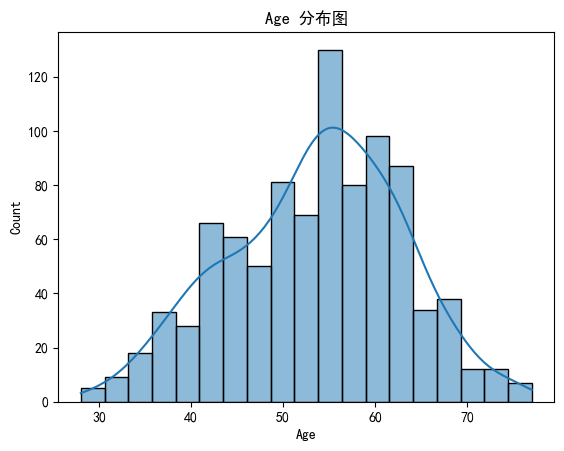

count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64


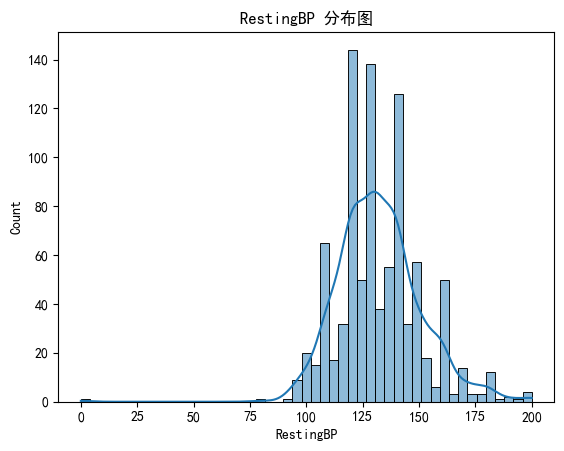

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


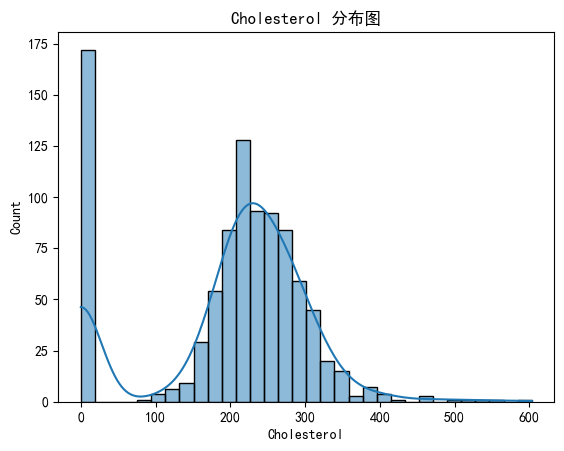

count    918.000000
mean       0.233115
std        0.423046
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64


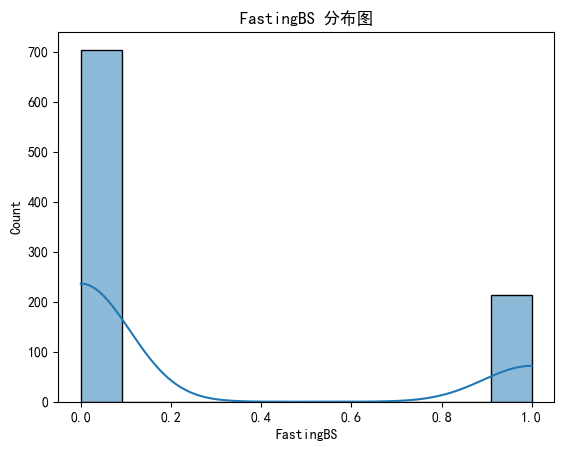

count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64


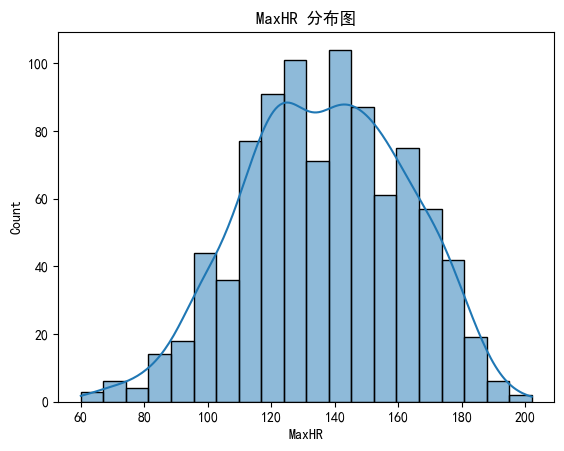

count    918.000000
mean       0.887364
std        1.066570
min       -2.600000
25%        0.000000
50%        0.600000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64


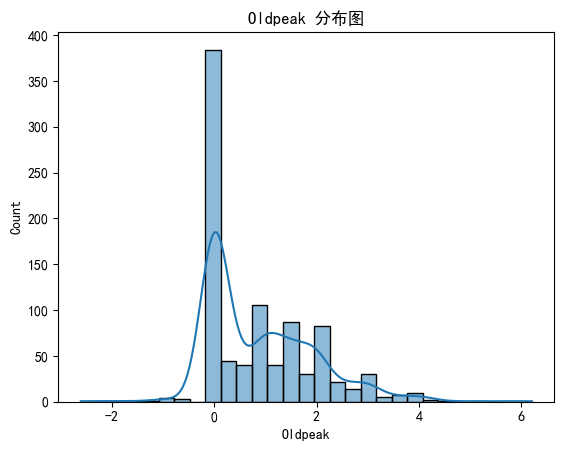

count    918.000000
mean       0.553377
std        0.497414
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: HeartDisease, dtype: float64


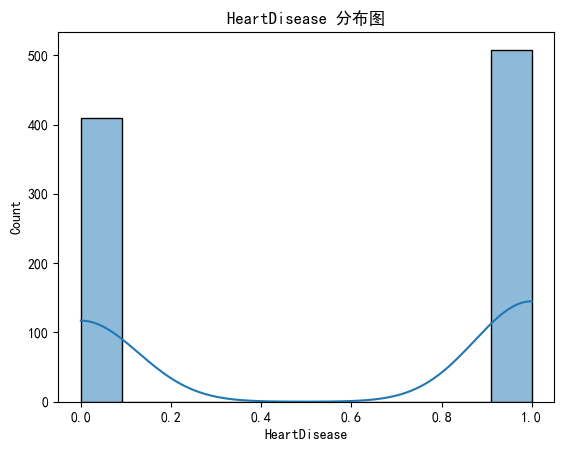

In [9]:
def summary_numeric(col):
    print(df[col].describe())
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} 分布图")
    plt.show()

for col in num_cols:
    summary_numeric(col)

##### 箱线图

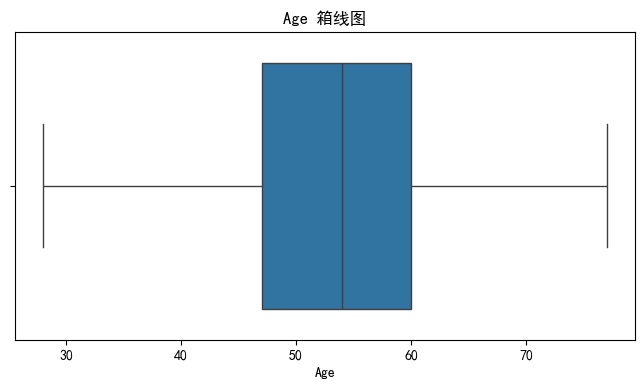

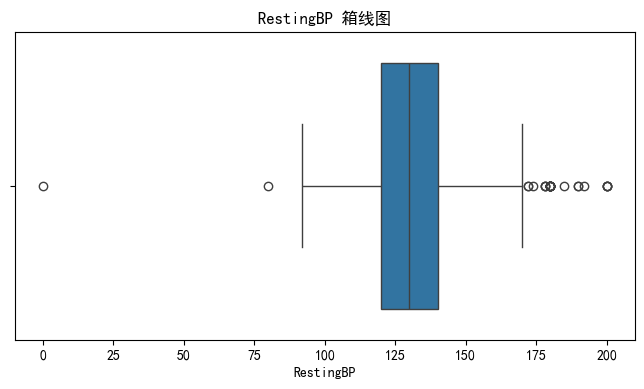

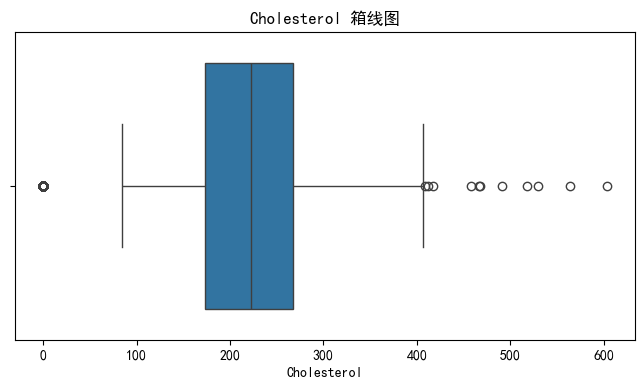

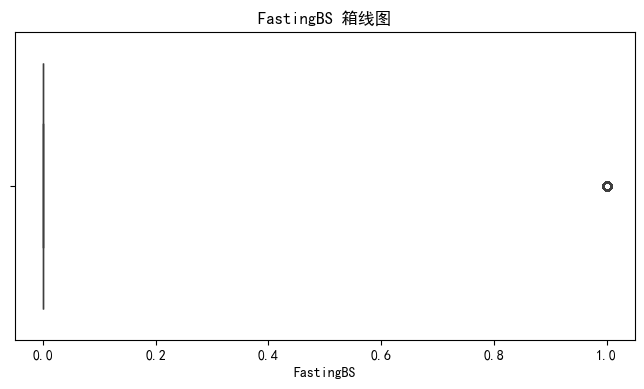

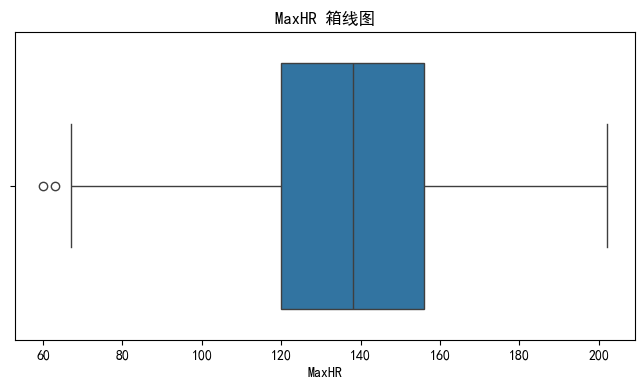

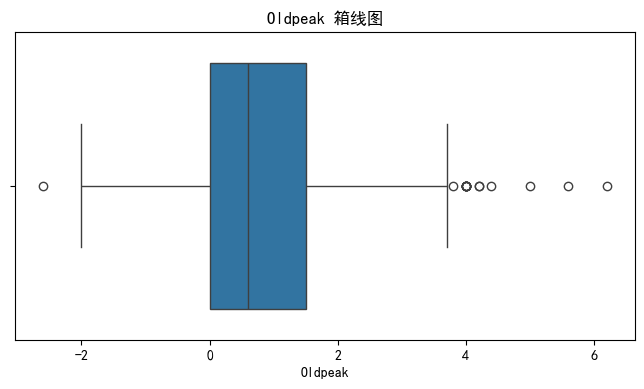

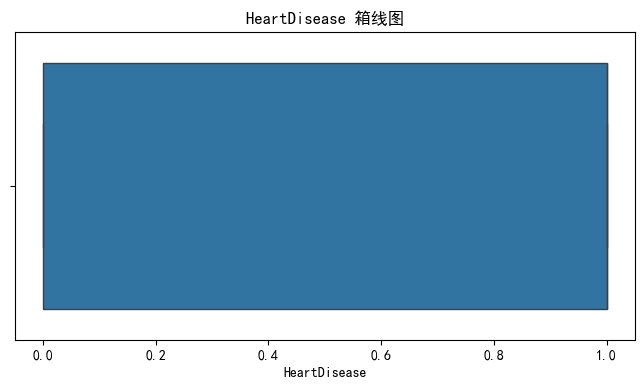

In [10]:
def boxplot_numeric(col):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"{col} 箱线图")
    plt.show()

for col in num_cols:
    boxplot_numeric(col)


##### 删除低方差列

In [11]:
# 设定方差阈值
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(threshold=0.1)
var_thresh.fit(df[num_cols])
# 选择高方差特征
high_var_features = df[num_cols].columns[var_thresh.get_support()]
print('删除低方差列之前的列数',len(num_cols))
print('删除低方差列之后的列数',len(high_var_features))

删除低方差列之前的列数 7
删除低方差列之后的列数 7


In [12]:
num_cols

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'HeartDisease']

In [13]:
high_var_features

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

##### 处理离群值

In [14]:
def outlier_thresholds(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

def check_outliers(data, col):
    lower, upper = outlier_thresholds(data, col)
    return data[(data[col] < lower) | (data[col] > upper)]

for col in high_var_features:
    print(f"{col} 异常值数量:", len(check_outliers(df, col)))

Age 异常值数量: 0
RestingBP 异常值数量: 28
Cholesterol 异常值数量: 183
FastingBS 异常值数量: 214
MaxHR 异常值数量: 2
Oldpeak 异常值数量: 16
HeartDisease 异常值数量: 0


In [15]:
def replace_outliers_with_median(data, col):
    lower, upper = outlier_thresholds(data, col)
    median = data[col].median()
    data[col] = np.where((data[col] < lower) | (data[col] > upper), median, data[col])

for col in high_var_features:
    replace_outliers_with_median(df, col)

##### 填补空值

In [16]:
from sklearn.impute import KNNImputer

# 假设 high_var_features 是你要填充的特征列
imputer = KNNImputer(n_neighbors=5)  # 设置 KNN 的邻居数量

# 使用 KNN 填充缺失值
df[high_var_features] = imputer.fit_transform(df[high_var_features])

# 检查填充后的缺失值数量
df[high_var_features].isnull().sum().sort_values(ascending=False).head(10)

Age             0
RestingBP       0
Cholesterol     0
FastingBS       0
MaxHR           0
Oldpeak         0
HeartDisease    0
dtype: int64

In [17]:
df.isnull().sum().sort_values(ascending=False).head(10)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
dtype: int64

##### 绘制初步处理后的分布图和箱线图

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


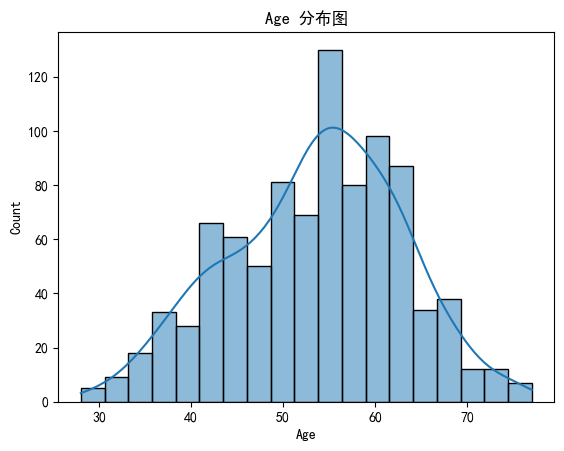

count    918.000000
mean     131.079521
std       15.597206
min       92.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      170.000000
Name: RestingBP, dtype: float64


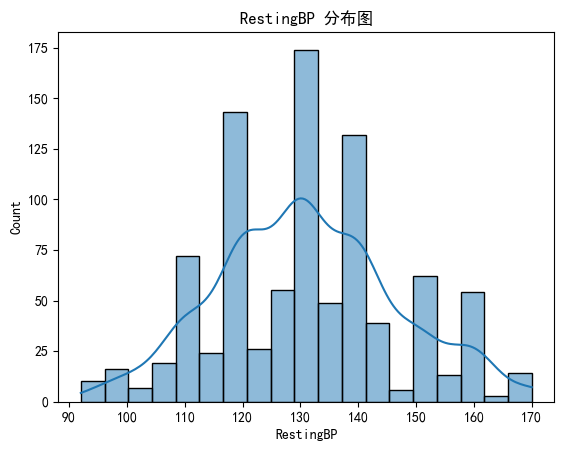

count    918.000000
mean     237.442266
std       46.339984
min       85.000000
25%      214.000000
50%      223.000000
75%      264.000000
max      407.000000
Name: Cholesterol, dtype: float64


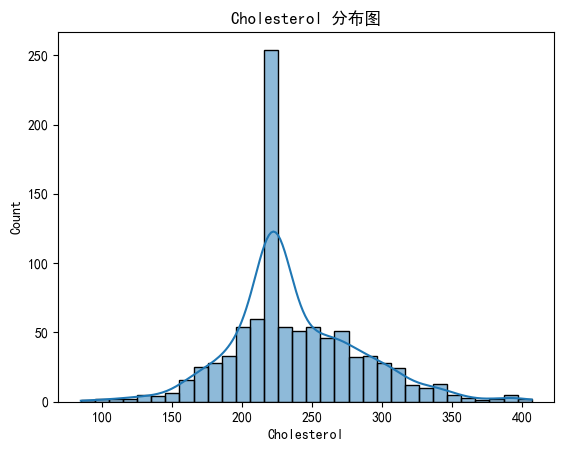

count    918.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: FastingBS, dtype: float64


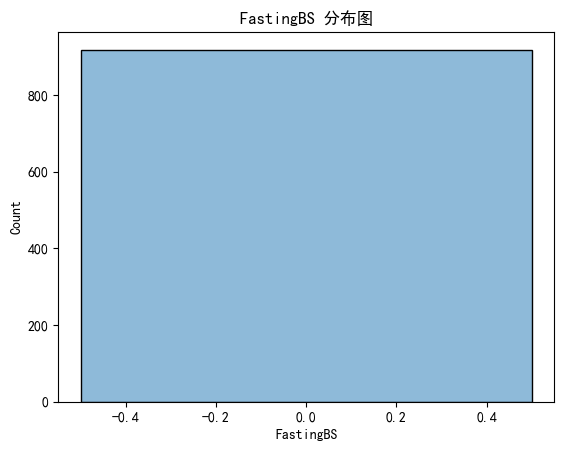

count    918.000000
mean     136.976035
std       25.215656
min       67.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64


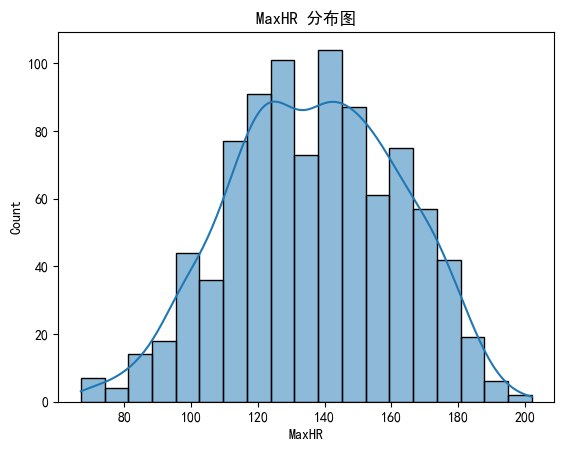

count    918.000000
mean       0.829412
std        0.958009
min       -2.000000
25%        0.000000
50%        0.600000
75%        1.500000
max        3.700000
Name: Oldpeak, dtype: float64


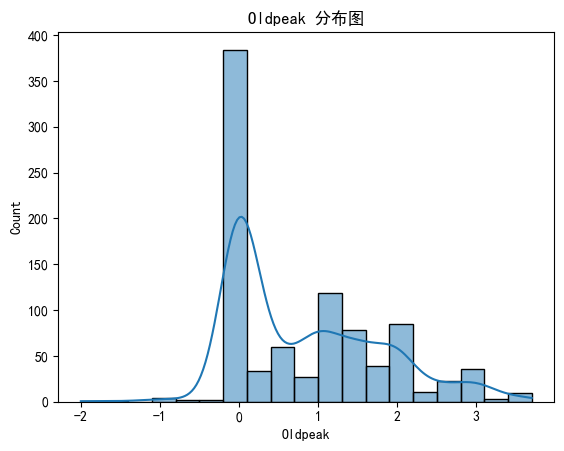

count    918.000000
mean       0.553377
std        0.497414
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: HeartDisease, dtype: float64


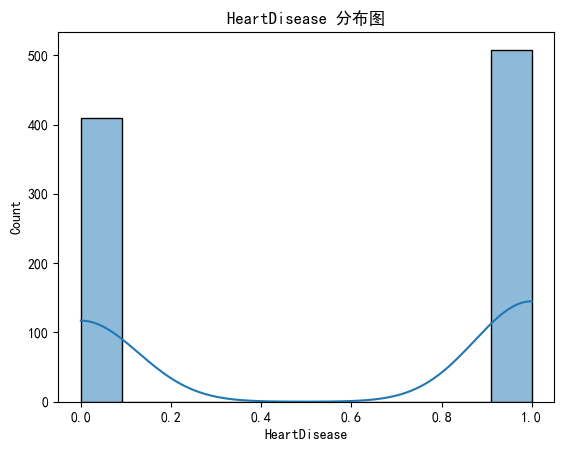

In [18]:
def summary_numeric(col):
    print(df[col].describe())
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} 分布图")
    plt.show()

for col in high_var_features:
    summary_numeric(col)

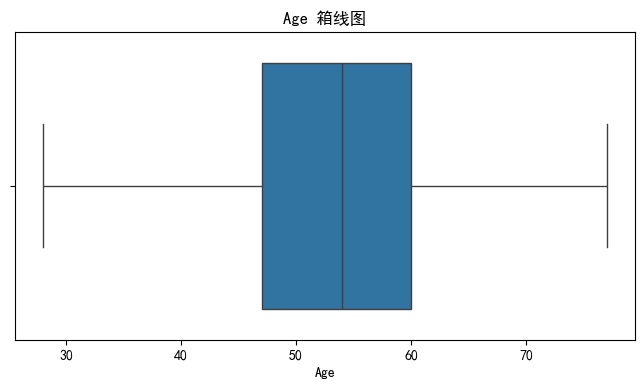

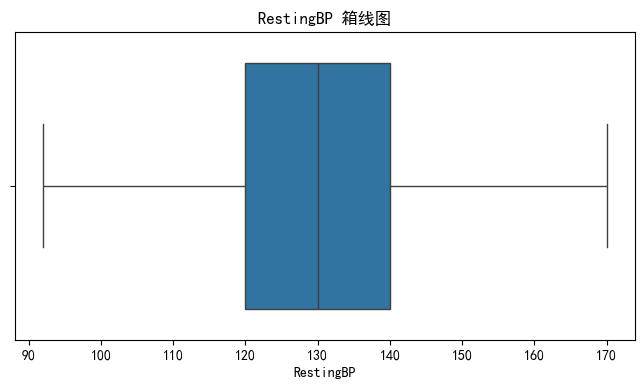

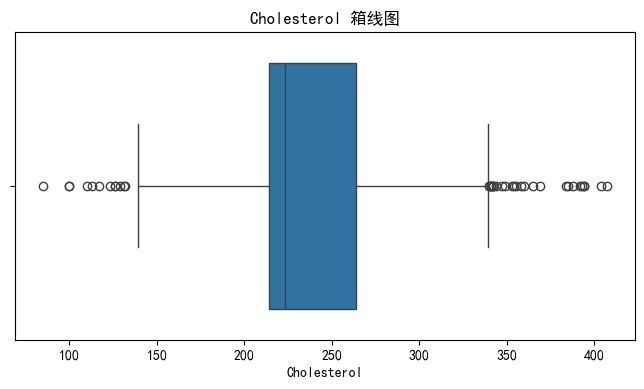

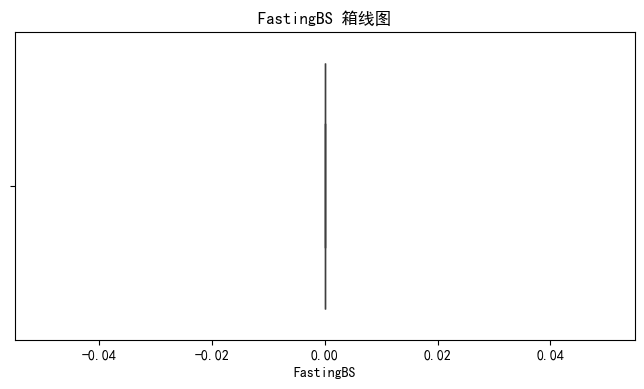

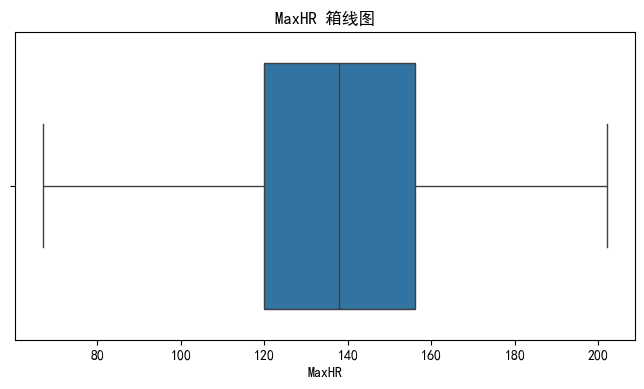

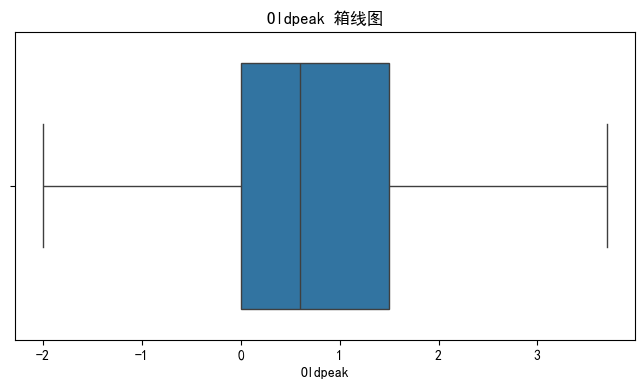

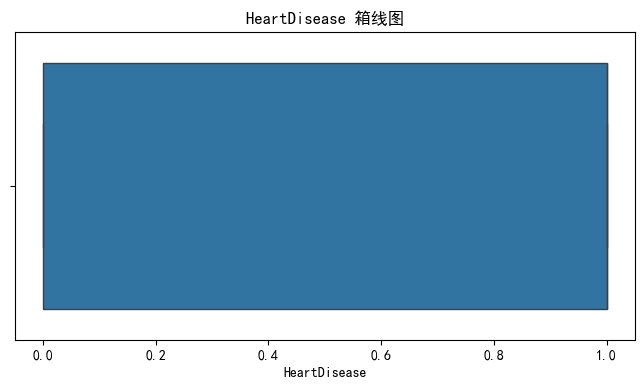

In [19]:
def boxplot_numeric(col):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"{col} 箱线图")
    plt.show()

for col in high_var_features:
    boxplot_numeric(col)

#### 分析分类特征

##### 查看唯一值

In [20]:
df[cat_cols].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

##### 编码

In [21]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_columns(df):
    """
    对分类列进行编码处理
    - 二分类变量：使用标签编码
    - 多分类变量：使用独热编码并转换为整数类型
    """

    label_encoder = LabelEncoder()

    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].nunique()

        if unique_vals == 2 or unique_vals == 1:
            # 标签编码
            df[col] = label_encoder.fit_transform(df[col])
        elif unique_vals > 2:
            # 独热编码 + 从布尔值转换为整数
            dummies = pd.get_dummies(df[col], prefix=col).astype(int)
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    return df

In [22]:
df = encode_categorical_columns(df)

In [23]:
df.isnull().sum().sort_values(ascending=False).head()

Age                  0
ChestPainType_ATA    0
ST_Slope_Flat        0
ST_Slope_Down        0
RestingECG_ST        0
dtype: int64

### 预处理结果

In [24]:
y = df['HeartDisease']
X = df.drop(['HeartDisease'], axis=1)

###  模型训练

#### 准备复用函数

In [25]:
# 混淆矩阵函数
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('混淆矩阵')
    plt.show()

In [26]:
# 基础评分
from sklearn.metrics import recall_score

def print_model_scores(pipe, X_test, y_test):
    print("模型得分:", pipe.score(X_test, y_test))
    print("召回率:", recall_score(y_test, pipe.predict(X_test)))
    print("AUC评分:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))


In [27]:
# 常用指标函数
def print_classification_report(y_true, y_pred):
    print("分类报告:\n", classification_report(y_true, y_pred))

In [28]:
# 绘制ROC曲线函数
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC曲线 (AUC = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('假阳性率')
    plt.ylabel('真阳性率')
    plt.title('ROC曲线')
    plt.legend()
    plt.show()

In [29]:
# 绘制PR曲线函数
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_true, y_pred_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='PR曲线 (AUC = {:.2f})'.format(auc(recall, precision)))
    plt.xlabel('召回率')
    plt.ylabel('精确率')
    plt.title('PR曲线')
    plt.legend()
    plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv=5):
    
    # 在测试集上评估
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f'\n{model_name} 测试集评估结果:')
    print(f'准确率: {accuracy:.4f}')
    print(f'精确率: {precision:.4f}')
    print(f'召回率: {recall:.4f}')
    
    # 交叉验证评估
    print(f'\n{model_name} 交叉验证结果 (cv={cv}):')
    # 交叉验证准确率
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'交叉验证准确率: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})')
    
    # 交叉验证精确率
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    print(f'交叉验证精确率: {cv_precision.mean():.4f} (±{cv_precision.std():.4f})')
    
    # 交叉验证召回率
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    print(f'交叉验证召回率: {cv_recall.mean():.4f} (±{cv_recall.std():.4f})')
    
    # 返回所有评估指标
    return {
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'cv_accuracy': (cv_accuracy.mean(), cv_accuracy.std()),
        'cv_precision': (cv_precision.mean(), cv_precision.std()),
        'cv_recall': (cv_recall.mean(), cv_recall.std())
    }

#### 切割数据集

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### XGBoost模型

开始网格搜索...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

网格搜索完成!
最佳参数: {'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}
最佳交叉验证分数: 0.9198

最佳模型在测试集上的表现:
模型得分: 0.8478260869565217
召回率: 0.8541666666666666
AUC评分: 0.9242424242424243

网格搜索完成!
最佳参数: {'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}
最佳交叉验证分数: 0.9198

最佳模型在测试集上的表现:
模型得分: 0.8478260869565217
召回率: 0.8541666666666666
AUC评分: 0.9242424242424243


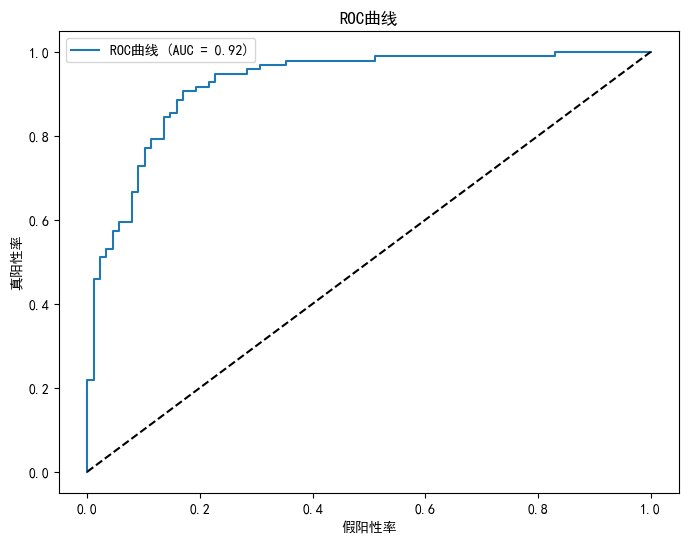

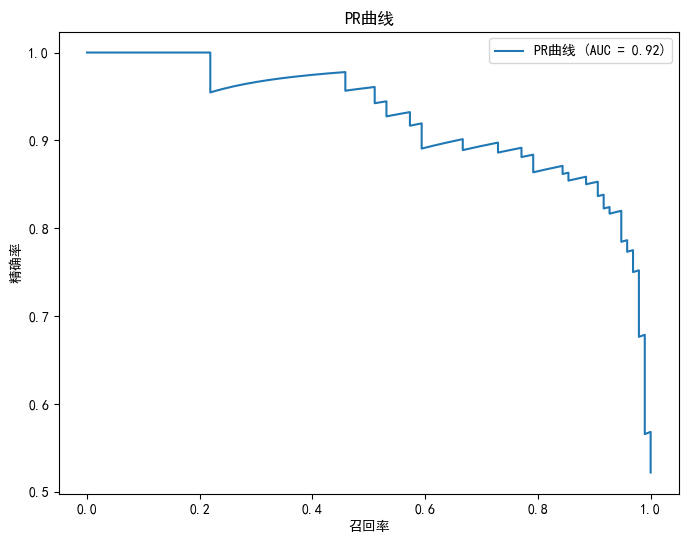


=== 网格搜索分析 ===
总共尝试了 243 种参数组合

表现最好的5种参数组合:
分数: 0.9198 (±0.0267)
参数: {'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}
---
分数: 0.9192 (±0.0272)
参数: {'XGB__colsample_bytree': 0.9, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}
---
分数: 0.9190 (±0.0280)
参数: {'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.9}
---
分数: 0.9188 (±0.0291)
参数: {'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 200, 'XGB__subsample': 0.8}
---
分数: 0.9186 (±0.0274)
参数: {'XGB__colsample_bytree': 1.0, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}
---

特征重要性排序 (前10):
1. ST_Slope_Up: 0.3360
2. ST_Slope_Flat: 0.1848
3. ExerciseAngina: 0.0791
4. ChestPainType_ASY: 0.0730
5. Sex: 0.0412
6. MaxHR: 0.0411
7. ChestPainT

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# 创建基础管道
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
pipe_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("XGB", xgb_model)
])

# 设置网格搜索参数
param_grid = {
    'XGB__n_estimators': [100, 200, 300],           # 树的数量
    'XGB__max_depth': [3, 5, 7],                    # 树的最大深度
    'XGB__learning_rate': [0.01, 0.1, 0.2],         # 学习率
    'XGB__subsample': [0.8, 0.9, 1.0],              # 样本采样比例
    'XGB__colsample_bytree': [0.8, 0.9, 1.0]        # 特征采样比例
}

# 设置交叉验证策略
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 创建网格搜索对象
grid_search = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',          # 使用AUC作为评估指标
    n_jobs=-1,                  # 使用所有CPU核心
    verbose=1,                  # 显示进度
    return_train_score=True     # 返回训练分数
)

# 执行网格搜索
print("开始网格搜索...")
grid_search.fit(X_train, y_train)

print("\n网格搜索完成!")
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")

# 使用最佳模型进行预测
best_pipe = grid_search.best_estimator_

# 评估最佳模型
print("\n最佳模型在测试集上的表现:")
print_model_scores(best_pipe, X_test, y_test)

# 绘制曲线
plot_roc_curve(y_test, best_pipe.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_pipe.predict_proba(X_test)[:, 1])

# 额外的分析信息
print("\n=== 网格搜索分析 ===")

# 查看所有参数组合的结果
results_df = pd.DataFrame(grid_search.cv_results_)
print(f"总共尝试了 {len(results_df)} 种参数组合")

# 查看前几名参数组合
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\n表现最好的5种参数组合:")
for i, row in top_results.iterrows():
    print(f"分数: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"参数: {row['params']}")
    print("---")

# 特征重要性分析（如果可用）
if hasattr(best_pipe.named_steps['XGB'], 'feature_importances_'):
    importances = best_pipe.named_steps['XGB'].feature_importances_
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    
    # 按重要性排序
    indices = np.argsort(importances)[::-1]
    print("\n特征重要性排序 (前10):")
    for i in range(min(10, len(importances))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

#### LightGBM模型

[I 2025-09-04 19:12:15,264] A new study created in memory with name: no-name-04817643-a428-4c03-8b05-6a905278cf09


开始使用 Optuna 优化 LightGBM（目标：召回率）...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-09-04 19:12:17,009] Trial 0 finished with value: 0.8980570541979619 and parameters: {'n_estimators': 200, 'learning_rate': 0.1540359659501924, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'reg_alpha': 5.360294728728285, 'reg_lambda': 0.31044435499483225}. Best is trial 0 with value: 0.8980570541979619.
[I 2025-09-04 19:12:19,292] Trial 1 finished with value: 0.9175394054797419 and parameters: {'n_estimators': 200, 'learning_rate': 0.002620503255096255, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'reg_alpha': 0.00012724181576752517, 'reg_lambda': 0.1165691561324743}. Best is trial 1 with value: 0.9175394054797419.
[I 2025-09-04 19:12:19,292] Trial 1 finished with value: 0.9175394054797419 and parameters: {'n_estimators': 200, 'learning_rate': 0.002620503255096255, 'num_leaves': 35, 'max_depth': 10, 'min_ch

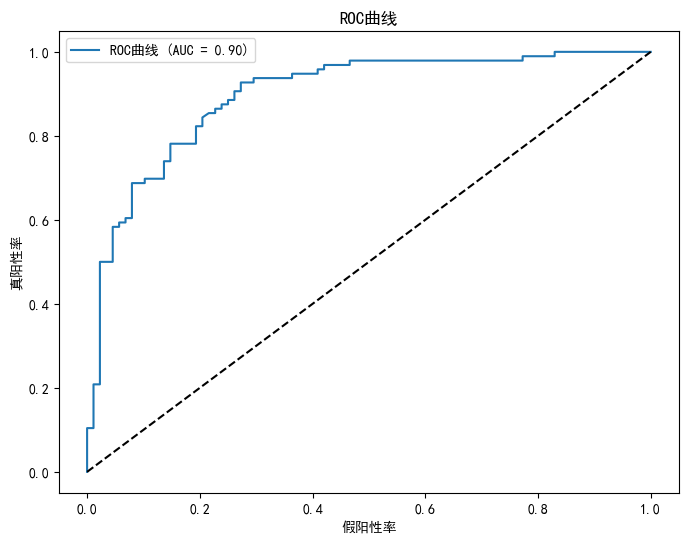

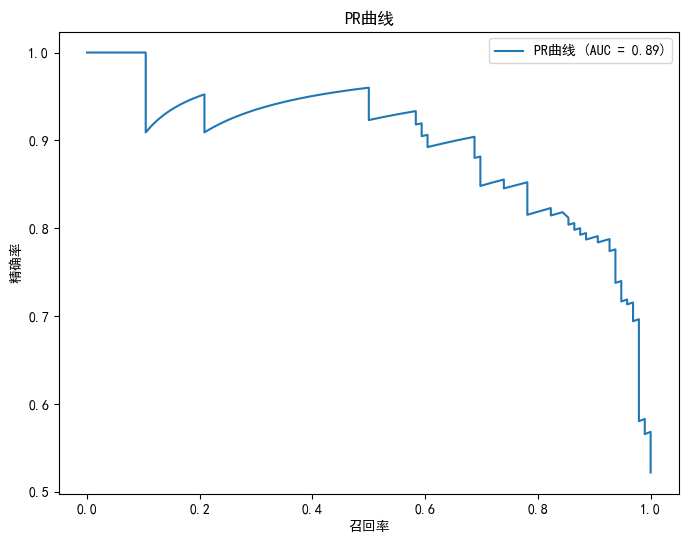


参数重要性:
min_child_samples: 0.2754
colsample_bytree: 0.2516
learning_rate: 0.1973
max_depth: 0.0742
num_leaves: 0.0638
subsample: 0.0531
n_estimators: 0.0498
reg_lambda: 0.0299
reg_alpha: 0.0050


In [33]:
from sklearn.metrics import recall_score, make_scorer, accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
warnings.filterwarnings("ignore")

# === 运行健壮性增强：数据与变量兜底 ===
# 若缺少 X,y，尝试从 df 或磁盘构建
if 'X' not in globals() or 'y' not in globals():
    if 'df' not in globals():
        default_path = os.path.join('data_set', 'heart.csv')
        if os.path.exists(default_path):
            df = pd.read_csv(default_path)
            print(f"📄 已从 {default_path} 读取数据集")
        else:
            raise RuntimeError("缺少 X,y/df，且默认数据集 data_set/heart.csv 不存在，请先运行上方数据准备单元。")
    if 'HeartDisease' in df.columns:
        y = df['HeartDisease']
        X = df.drop(['HeartDisease'], axis=1)
        print("⚙️ 已根据 df 生成 X,y（目标列: HeartDisease）")
    else:
        raise RuntimeError("df 中不存在列 'HeartDisease'，请检查数据准备流程。")

# 若未拆分数据，则基于 X,y 自动拆分
if 'X_train' not in globals() or 'y_train' not in globals():
    try:
        stratify = y if hasattr(y, 'values') else y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify, random_state=42)
        print("⚙️ 已自动基于 X,y 进行 train_test_split (test_size=0.2, stratify=y)")
    except Exception:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print("⚙️ 已自动进行 train_test_split (未分层)")

# 识别数值/类别列，并构建统一预处理器
num_cols = X_train.select_dtypes(include=['number', 'bool']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
def make_preprocessor():
    transformers = []
    if len(num_cols) > 0:
        transformers.append(('num', StandardScaler(with_mean=False), num_cols))
    if len(cat_cols) > 0:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols))
    return ColumnTransformer(transformers=transformers)

# 若缺少评估与可视化函数，提供简化兜底实现
if 'print_model_scores' not in globals():
    def print_model_scores(model, X_te, y_te):
        proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_te)
        pred = (proba >= 0.5).astype(int) if np.ndim(proba) == 1 else model.predict(X_te)
        acc = accuracy_score(y_te, pred)
        rec = recall_score(y_te, pred, pos_label=1)
        prec = precision_score(y_te, pred, zero_division=0)
        f1 = f1_score(y_te, pred)
        auc = roc_auc_score(y_te, proba) if np.ndim(proba) == 1 else np.nan
        print(f"Accuracy: {acc:.4f}  Recall: {rec:.4f}  Precision: {prec:.4f}  F1: {f1:.4f}  AUC: {auc:.4f}")

if 'plot_roc_curve' not in globals():
    def plot_roc_curve(y_true, y_score):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC AUC={auc_val:.3f}')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

if 'plot_pr_curve' not in globals():
    def plot_pr_curve(y_true, y_score):
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        plt.figure()
        plt.plot(rec, prec, label=f'AP={ap:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

# 使用 Optuna 优化 LightGBM，目标：最大化少数类召回率
try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
except ImportError:
    raise ImportError("未安装 optuna，请先安装：pip install optuna")

from lightgbm import LGBMClassifier

# 定义召回率评分器（正类为1）
recall_scorer = make_scorer(recall_score, pos_label=1)

def objective(trial):
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 127),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 4, 6, 8, 10]),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 80),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "verbosity": -1,
        "force_col_wise": True,
    }

    lgbm_model = LGBMClassifier(**params)
    pre = make_preprocessor()
    pipe_lgbm = Pipeline([
        ("pre", pre),
        ("LGBM", lgbm_model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe_lgbm, X_train, y_train, cv=cv, scoring=recall_scorer, n_jobs=-1)
    return float(scores.mean())

# 建立 Study 并优化
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

print("开始使用 Optuna 优化 LightGBM（目标：召回率）...")
study.optimize(objective, n_trials=40, timeout=600, show_progress_bar=True)

print("\nOptuna 完成!")
print(f"最佳参数: {study.best_params}")
print(f"最佳交叉验证召回率: {study.best_value:.4f}")

# 使用最佳参数训练最终模型并评估
best_params = study.best_params.copy()
best_lgbm = LGBMClassifier(**{
    **best_params,
    "objective": "binary",
    "boosting_type": "gbdt",
    "random_state": 42,
    "verbosity": -1,
    "force_col_wise": True,
})
best_model = Pipeline([
    ("pre", make_preprocessor()),
    ("LGBM", best_lgbm)
])
best_model.fit(X_train, y_train)

print("\n最佳模型在测试集上的表现:")
y_score = best_model.predict_proba(X_test)[:, 1]
print_model_scores(best_model, X_test, y_test)
plot_roc_curve(y_test, y_score)
plot_pr_curve(y_test, y_score)

# 参数重要性（可选）
try:
    from optuna.importance import get_param_importances
    imps = get_param_importances(study)
    print("\n参数重要性:")
    for k, v in imps.items():
        print(f"{k}: {v:.4f}")
except Exception:
    pass

#### KNN

开始KNN随机搜索...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

最佳参数: {'KNN__algorithm': 'brute', 'KNN__n_neighbors': 5, 'KNN__p': 1, 'KNN__weights': 'uniform'}
最佳交叉验证召回率: 0.8811

测试集性能:
模型得分: 0.8478260869565217
召回率: 0.8229166666666666

最佳参数: {'KNN__algorithm': 'brute', 'KNN__n_neighbors': 5, 'KNN__p': 1, 'KNN__weights': 'uniform'}
最佳交叉验证召回率: 0.8811

测试集性能:
模型得分: 0.8478260869565217
召回率: 0.8229166666666666
AUC评分: 0.8763020833333334
AUC评分: 0.8763020833333334


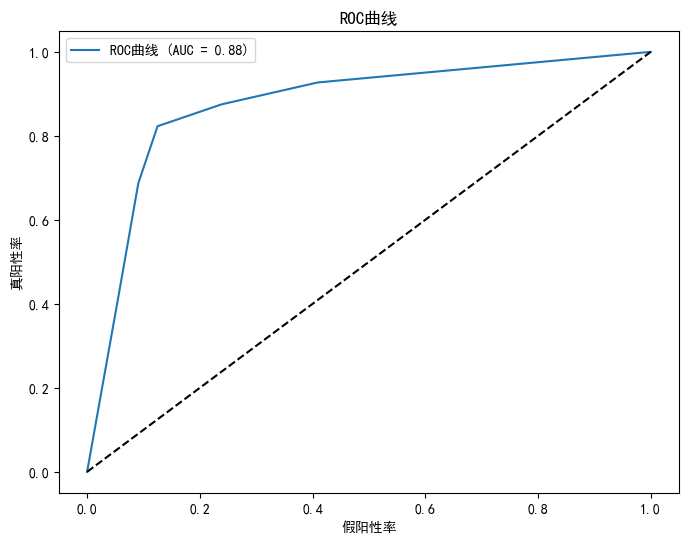

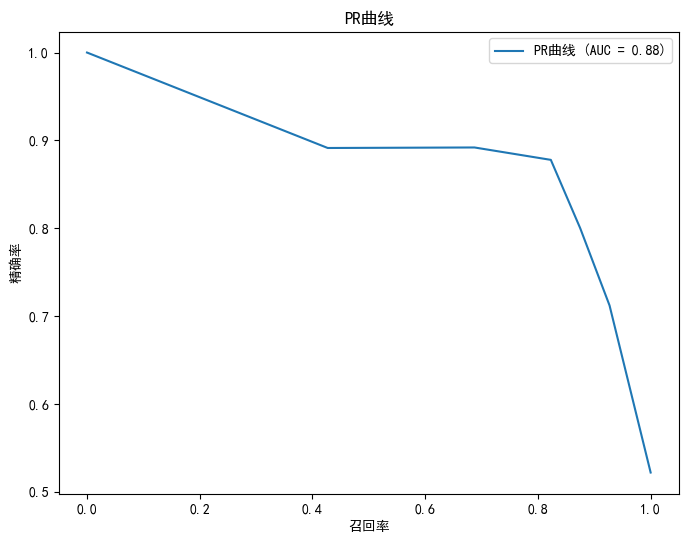

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import randint

# 首先定义KNN管道
knn_model = KNeighborsClassifier()
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("KNN", knn_model)
])

# 定义自定义评估指标 - 召回率
recall_scorer = make_scorer(recall_score, pos_label=1)

# 定义参数分布
param_dist = {
    'KNN__n_neighbors': randint(3, 20),          # 3到20之间的随机整数
    'KNN__weights': ['uniform', 'distance'],
    'KNN__p': [1, 2],
    'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_dist,
    n_iter=20,  # 迭代次数
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 减少折数
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

# 执行随机搜索
print("开始KNN随机搜索...")
random_search.fit(X_train, y_train)

# 输出结果
print(f"\n最佳参数: {random_search.best_params_}")
print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")

best_knn_model = random_search.best_estimator_
print("\n测试集性能:")
print_model_scores(best_knn_model, X_test, y_test)
plot_roc_curve(y_test, best_knn_model.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_knn_model.predict_proba(X_test)[:, 1])

#### SVM

开始SVM随机搜索...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

最佳参数: {'SVM__C': 3.8115440886530614, 'SVM__degree': 3, 'SVM__gamma': 0.000602521573620386, 'SVM__kernel': 'poly'}
最佳交叉验证召回率: 1.0000

测试集性能:
模型得分: 0.5217391304347826
召回率: 1.0
AUC评分: 0.903527462121212

最佳参数: {'SVM__C': 3.8115440886530614, 'SVM__degree': 3, 'SVM__gamma': 0.000602521573620386, 'SVM__kernel': 'poly'}
最佳交叉验证召回率: 1.0000

测试集性能:
模型得分: 0.5217391304347826
召回率: 1.0
AUC评分: 0.903527462121212


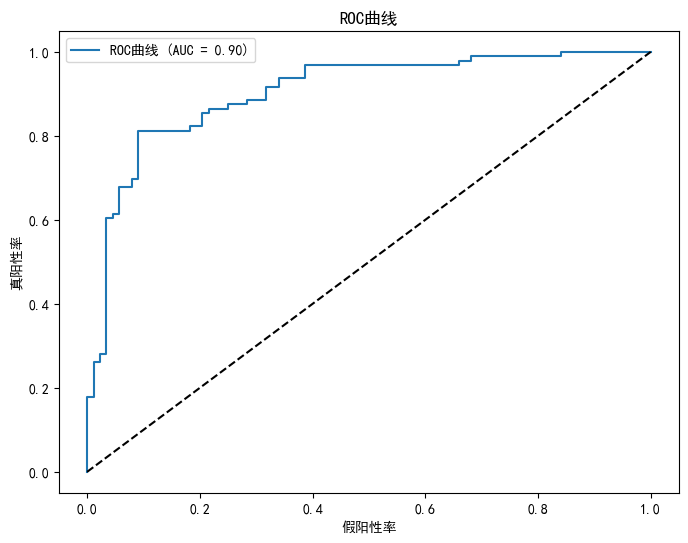

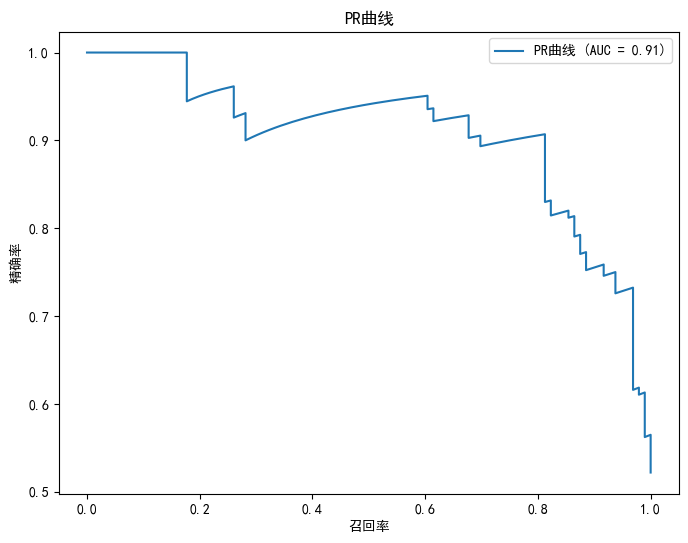

In [35]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score

# 定义召回率评分器
recall_scorer = make_scorer(recall_score)

# 首先定义SVM管道
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),  # SVM通常需要特征缩放
    ("SVM", SVC(probability=True, random_state=42))  # 注意这里的名称是"SVM"，要与参数分布中的前缀一致
])

# 定义参数分布
param_dist = {
    'SVM__C': loguniform(1e-3, 1e3),  # 对数均匀分布，覆盖更大范围
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': loguniform(1e-4, 1e1),
    'SVM__degree': [2, 3, 4]
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_svm,  # 现在pipe_svm已经定义
    param_distributions=param_dist,
    n_iter=30,  # 迭代次数
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 减少折数
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

# 执行随机搜索
print("开始SVM随机搜索...")
random_search.fit(X_train, y_train)

# 输出结果
print(f"\n最佳参数: {random_search.best_params_}")
print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")

best_svm_model = random_search.best_estimator_
print("\n测试集性能:")
print_model_scores(best_svm_model, X_test, y_test)
plot_roc_curve(y_test, best_svm_model.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_svm_model.predict_proba(X_test)[:, 1])

#### 随机森林

开始随机森林随机搜索...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

最佳参数: {'RF__bootstrap': True, 'RF__class_weight': None, 'RF__max_depth': 31, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 9, 'RF__min_samples_split': 14, 'RF__n_estimators': 332}
最佳交叉验证召回率: 0.8956

测试集性能:
模型得分: 0.8532608695652174
召回率: 0.8645833333333334
AUC评分: 0.9209280303030304

最佳参数: {'RF__bootstrap': True, 'RF__class_weight': None, 'RF__max_depth': 31, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 9, 'RF__min_samples_split': 14, 'RF__n_estimators': 332}
最佳交叉验证召回率: 0.8956

测试集性能:
模型得分: 0.8532608695652174
召回率: 0.8645833333333334
AUC评分: 0.9209280303030304


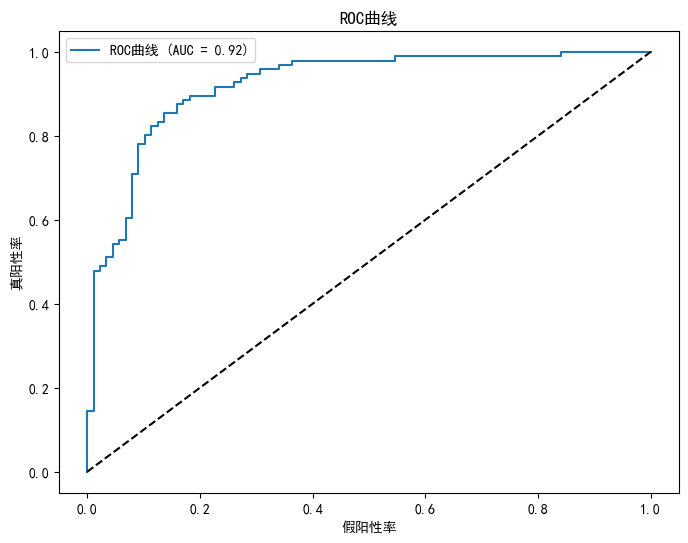

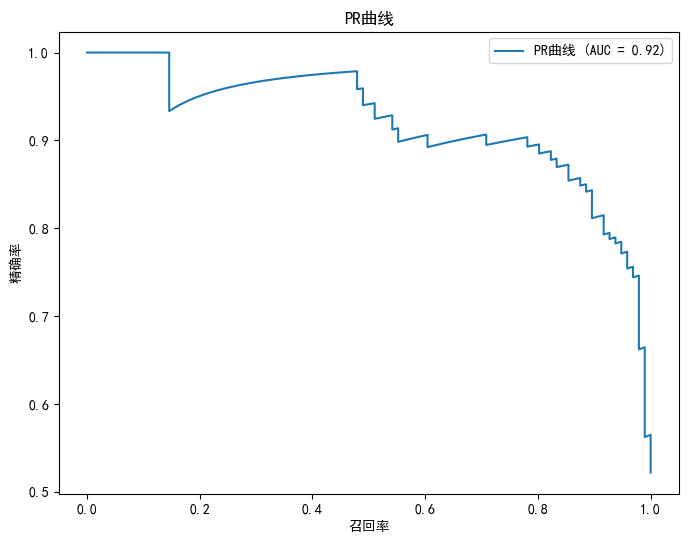

In [36]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # 随机森林对特征缩放不敏感，可根据需要选择
from sklearn.metrics import make_scorer, recall_score

# 定义召回率评分器（如果之前没定义的话）
recall_scorer = make_scorer(recall_score)

# 定义随机森林管道
pipe_rf = Pipeline([
    # 注意：随机森林通常不需要特征缩放，这里保留是为了保持与其他模型的一致性
    # 实际应用中可以移除StandardScaler
    ("scaler", StandardScaler()),  
    ("RF", RandomForestClassifier(random_state=42))  # 名称"RF"需与参数分布中的前缀一致
])

# 定义参数分布
param_dist = {
    'RF__n_estimators': randint(100, 500),           # 100-500之间的树
    'RF__max_depth': randint(5, 50),                 # 5-50的深度
    'RF__min_samples_split': randint(2, 20),         # 2-20的最小分割样本
    'RF__min_samples_leaf': randint(1, 10),          # 1-10的最小叶子样本
    'RF__max_features': ['sqrt', 'log2', None],      # 特征选择方式
    'RF__bootstrap': [True, False],
    'RF__class_weight': [None, 'balanced', 'balanced_subsample']
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_rf,  # 现在pipe_rf已定义
    param_distributions=param_dist,
    n_iter=50,  # 迭代次数
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

# 执行随机搜索
print("开始随机森林随机搜索...")
random_search.fit(X_train, y_train)

# 输出结果
print(f"\n最佳参数: {random_search.best_params_}")
print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")

best_rf_model = random_search.best_estimator_
print("\n测试集性能:")
print_model_scores(best_rf_model, X_test, y_test)
plot_roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])

#### 逻辑回归

开始逻辑回归随机搜索...
训练数据形状: (734, 18)
正样本比例: 0.561
Fitting 5 folds for each of 50 candidates, totalling 250 fits

搜索完成! 耗时: 1.29秒
最佳参数: {'LR__C': 0.00011025488264291667, 'LR__class_weight': None, 'LR__l1_ratio': 0.2912291401980419, 'LR__penalty': 'l2', 'LR__solver': 'sag'}
最佳交叉验证召回率: 1.0000

最佳5个参数组合:
1. 召回率: 1.0000, 参数: {'LR__C': 0.00011025488264291667, 'LR__class_weight': None, 'LR__l1_ratio': 0.2912291401980419, 'LR__penalty': 'l2', 'LR__solver': 'sag'}
2. 召回率: 1.0000, 参数: {'LR__C': 0.00010072151787441792, 'LR__class_weight': None, 'LR__l1_ratio': 0.8607305832563434, 'LR__penalty': 'l2', 'LR__solver': 'sag'}
3. 召回率: 0.9951, 参数: {'LR__C': 0.00028965395242758657, 'LR__class_weight': None, 'LR__l1_ratio': 0.6947849330397046, 'LR__penalty': 'l2', 'LR__solver': 'saga'}
4. 召回率: 0.9272, 参数: {'LR__C': 0.0012329623163659848, 'LR__class_weight': None, 'LR__l1_ratio': 0.6174815096277165, 'LR__penalty': 'l2', 'LR__solver': 'newton-cg'}
5. 召回率: 0.9029, 参数: {'LR__C': 0.008935110590331868, 'LR__class_we

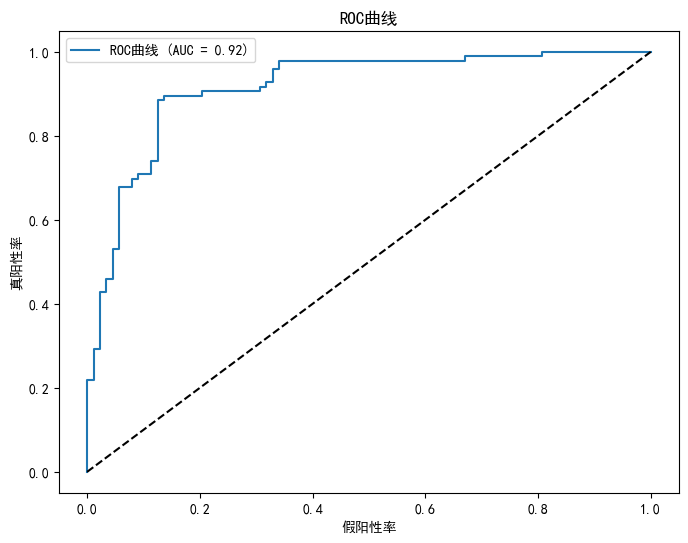

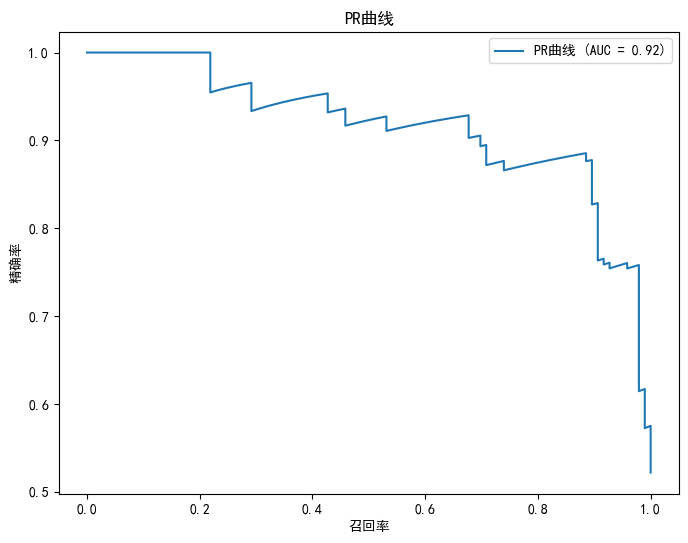


特征重要性 (前10个):
              feature  importance
17        ST_Slope_Up    0.023754
16      ST_Slope_Flat    0.021074
6      ExerciseAngina    0.018796
8   ChestPainType_ASY    0.018767
9   ChestPainType_ATA    0.015727
7             Oldpeak    0.015483
5               MaxHR    0.015277
1                 Sex    0.011639
0                 Age    0.010698
10  ChestPainType_NAP    0.006692


In [37]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.filterwarnings('ignore')

# 定义召回率评分器
recall_scorer = make_scorer(recall_score, average='binary', zero_division=0)

# 定义逻辑回归管道
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("LR", LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1))
])

# 优化参数分布 - 考虑参数兼容性
param_dist = [
    # 对于liblinear和saga solver，支持l1和l2惩罚
    {
        'LR__solver': ['liblinear', 'saga'],
        'LR__penalty': ['l1', 'l2'],
        'LR__C': loguniform(1e-4, 1e2),
        'LR__class_weight': [None, 'balanced'],
        'LR__l1_ratio': uniform(0, 1)  # 仅对elasticnet有效，但这里不会冲突
    },
    # 对于lbfgs/newton-cg/sag solver，只支持l2惩罚
    {
        'LR__solver': ['lbfgs', 'newton-cg', 'sag'],
        'LR__penalty': ['l2'],
        'LR__C': loguniform(1e-4, 1e2),
        'LR__class_weight': [None, 'balanced'],
        'LR__l1_ratio': uniform(0, 1)
    },
    # 对于elasticnet惩罚，只支持saga solver
    {
        'LR__solver': ['saga'],
        'LR__penalty': ['elasticnet'],
        'LR__C': loguniform(1e-4, 1e2),
        'LR__class_weight': [None, 'balanced'],
        'LR__l1_ratio': uniform(0, 1)
    },
    # 无惩罚项的情况
    {
        'LR__penalty': [None],
        'LR__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'LR__class_weight': [None, 'balanced'],
        'LR__C': [1.0],  # 无惩罚时C参数无效，设为固定值
        'LR__l1_ratio': [0.5]  # 无效参数设为固定值
    }
]

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=param_dist,
    n_iter=50,  # 增加迭代次数以获得更好的结果
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 增加交叉验证折数
    n_jobs=-1,
    verbose=2,  # 更详细的输出
    random_state=42,
    refit=True,
    error_score='raise'  # 遇到错误时抛出异常以便调试
)

print("开始逻辑回归随机搜索...")
print(f"训练数据形状: {X_train.shape}")
print(f"正样本比例: {y_train.mean():.3f}")

# 添加计时功能
import time
start_time = time.time()

try:
    random_search.fit(X_train, y_train)
    end_time = time.time()
    
    print(f"\n搜索完成! 耗时: {end_time - start_time:.2f}秒")
    print(f"最佳参数: {random_search.best_params_}")
    print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")
    
    # 显示所有尝试的结果
    results_df = pd.DataFrame(random_search.cv_results_)
    print(f"\n最佳5个参数组合:")
    top_5 = results_df.nlargest(5, 'mean_test_score')
    for i, (_, row) in enumerate(top_5.iterrows()):
        print(f"{i+1}. 召回率: {row['mean_test_score']:.4f}, 参数: {row['params']}")
    
    best_random_model = random_search.best_estimator_
    
    print("\n测试集性能:")
    print_model_scores(best_random_model, X_test, y_test)
    
    # 绘制曲线
    plot_roc_curve(y_test, best_random_model.predict_proba(X_test)[:, 1])
    plot_pr_curve(y_test, best_random_model.predict_proba(X_test)[:, 1])
    
    # 特征重要性（对于线性模型）
    if hasattr(best_random_model.named_steps['LR'], 'coef_'):
        print("\n特征重要性 (前10个):")
        coef = best_random_model.named_steps['LR'].coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_train.columns if hasattr(X_train, 'columns') else range(len(coef)),
            'importance': abs(coef)
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print(feature_importance.head(10))
        
except Exception as e:
    print(f"搜索过程中出现错误: {e}")
    print("建议检查参数兼容性或减少参数搜索空间")

#### GBDT

开始GBDT随机搜索...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

最佳参数组合: {'GBDT__learning_rate': 0.14379765094284575, 'GBDT__max_depth': 7, 'GBDT__max_features': None, 'GBDT__min_samples_leaf': 9, 'GBDT__min_samples_split': 4, 'GBDT__n_estimators': 202, 'GBDT__subsample': 0.7015184751538656, 'GBDT__validation_fraction': 0.2}
最佳交叉验证召回率: 0.9029

测试集性能:
模型得分: 0.842391304347826
召回率: 0.8541666666666666
AUC评分: 0.9083806818181818

最佳参数组合: {'GBDT__learning_rate': 0.14379765094284575, 'GBDT__max_depth': 7, 'GBDT__max_features': None, 'GBDT__min_samples_leaf': 9, 'GBDT__min_samples_split': 4, 'GBDT__n_estimators': 202, 'GBDT__subsample': 0.7015184751538656, 'GBDT__validation_fraction': 0.2}
最佳交叉验证召回率: 0.9029

测试集性能:
模型得分: 0.842391304347826
召回率: 0.8541666666666666
AUC评分: 0.9083806818181818


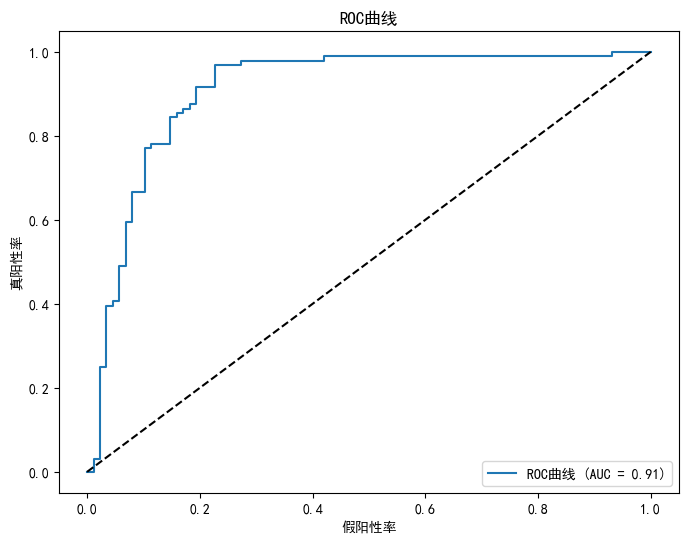

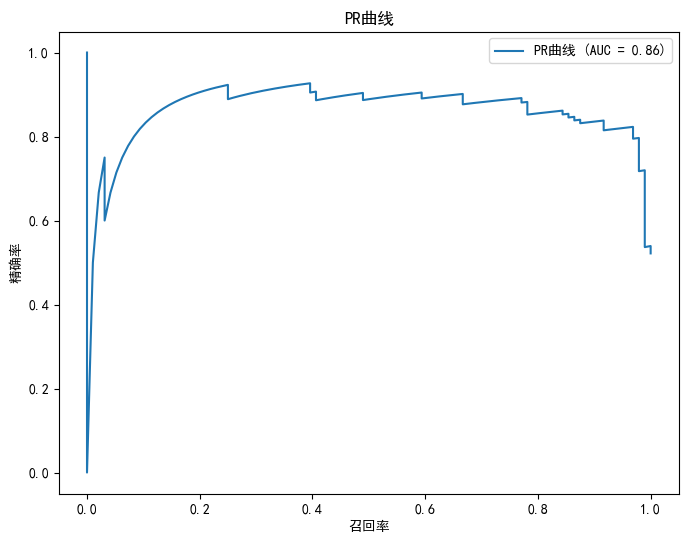

In [38]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score

# 定义召回率评分器
recall_scorer = make_scorer(
    recall_score,
    average='binary'
)

# 定义GBDT的Pipeline管道，修复参数错误
pipe_gbdt = Pipeline([
    ("scaler", StandardScaler()),
    ("GBDT", GradientBoostingClassifier(
        random_state=42,
        n_iter_no_change=10,  # 正确参数：连续10轮无改善则停止
        validation_fraction=0.1  # 用于早停的验证集比例
    ))
])

# 定义参数分布
param_dist = {
    'GBDT__n_estimators': randint(50, 500),
    'GBDT__learning_rate': uniform(0.01, 0.2),
    'GBDT__max_depth': randint(2, 8),
    'GBDT__min_samples_split': randint(2, 20),
    'GBDT__min_samples_leaf': randint(1, 10),
    'GBDT__subsample': uniform(0.7, 0.3),
    'GBDT__max_features': ['sqrt', 'log2', None],
    'GBDT__validation_fraction': [0.1, 0.2]
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_gbdt,
    param_distributions=param_dist,
    n_iter=50,
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

print("开始GBDT随机搜索...")
random_search.fit(X_train, y_train)

print(f"\n最佳参数组合: {random_search.best_params_}")
print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")

best_random_model = random_search.best_estimator_
print("\n测试集性能:")
print_model_scores(best_random_model, X_test, y_test)
plot_roc_curve(y_test, best_random_model.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_random_model.predict_proba(X_test)[:, 1])

#### CatBoost

开始CatBoost随机搜索...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

最佳参数组合: {'CatBoost__bagging_temperature': 0.12706051265188478, 'CatBoost__border_count': 39, 'CatBoost__depth': 8, 'CatBoost__iterations': 159, 'CatBoost__l2_leaf_reg': 3.1582102749684315, 'CatBoost__learning_rate': 0.19686714274570008, 'CatBoost__od_type': 'Iter', 'CatBoost__od_wait': 15, 'CatBoost__random_strength': 2.033634423372154}
最佳交叉验证召回率: 0.9054

测试集性能:
模型得分: 0.8586956521739131
召回率: 0.84375
AUC评分: 0.9300426136363636

最佳参数组合: {'CatBoost__bagging_temperature': 0.12706051265188478, 'CatBoost__border_count': 39, 'CatBoost__depth': 8, 'CatBoost__iterations': 159, 'CatBoost__l2_leaf_reg': 3.1582102749684315, 'CatBoost__learning_rate': 0.19686714274570008, 'CatBoost__od_type': 'Iter', 'CatBoost__od_wait': 15, 'CatBoost__random_strength': 2.033634423372154}
最佳交叉验证召回率: 0.9054

测试集性能:
模型得分: 0.8586956521739131
召回率: 0.84375
AUC评分: 0.9300426136363636


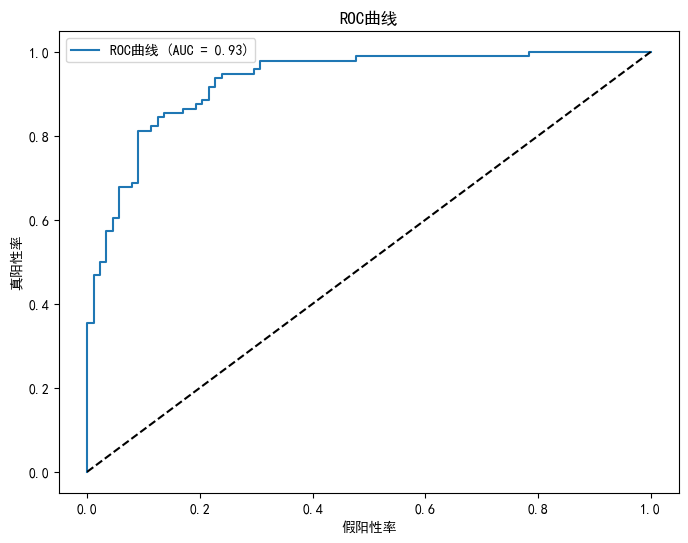

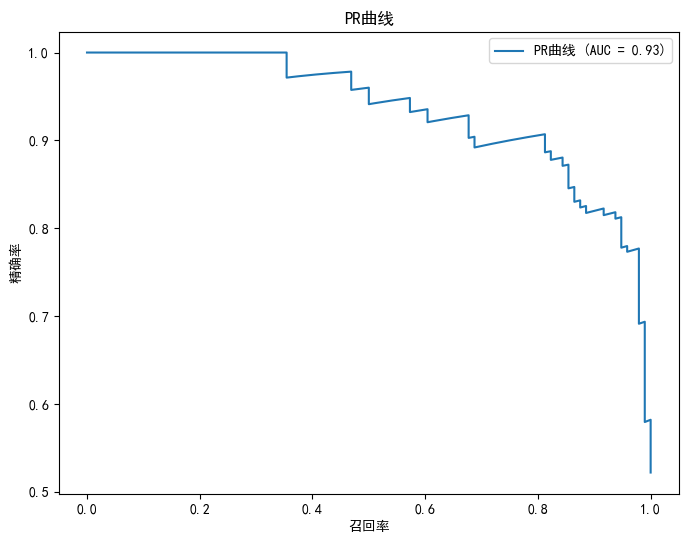

In [39]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score

# 定义召回率评分器
recall_scorer = make_scorer(
    recall_score,
    average='binary'
)

# 定义CatBoost的Pipeline管道
pipe_catboost = Pipeline([
    ("scaler", StandardScaler()),
    ("CatBoost", CatBoostClassifier(
        random_state=42,
        verbose=False,
        thread_count=-1  # 使用所有可用线程
    ))
])

# 定义参数分布
param_dist = {
    'CatBoost__iterations': randint(100, 500),
    'CatBoost__learning_rate': uniform(0.01, 0.3),
    'CatBoost__depth': randint(4, 10),
    'CatBoost__l2_leaf_reg': uniform(1, 10),
    'CatBoost__border_count': randint(32, 255),
    'CatBoost__bagging_temperature': uniform(0, 1),
    'CatBoost__random_strength': uniform(1, 20),
    'CatBoost__od_type': ['IncToDec', 'Iter'],
    'CatBoost__od_wait': randint(10, 50)
}

# 创建随机搜索对象
random_search = RandomizedSearchCV(
    estimator=pipe_catboost,
    param_distributions=param_dist,
    n_iter=50,
    scoring=recall_scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True
)

print("开始CatBoost随机搜索...")
random_search.fit(X_train, y_train)

print(f"\n最佳参数组合: {random_search.best_params_}")
print(f"最佳交叉验证召回率: {random_search.best_score_:.4f}")

best_catboost_model = random_search.best_estimator_
print("\n测试集性能:")
print_model_scores(best_catboost_model, X_test, y_test)
plot_roc_curve(y_test, best_catboost_model.predict_proba(X_test)[:, 1])
plot_pr_curve(y_test, best_catboost_model.predict_proba(X_test)[:, 1])

### 模型对比

模型 GBDT 评估失败: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


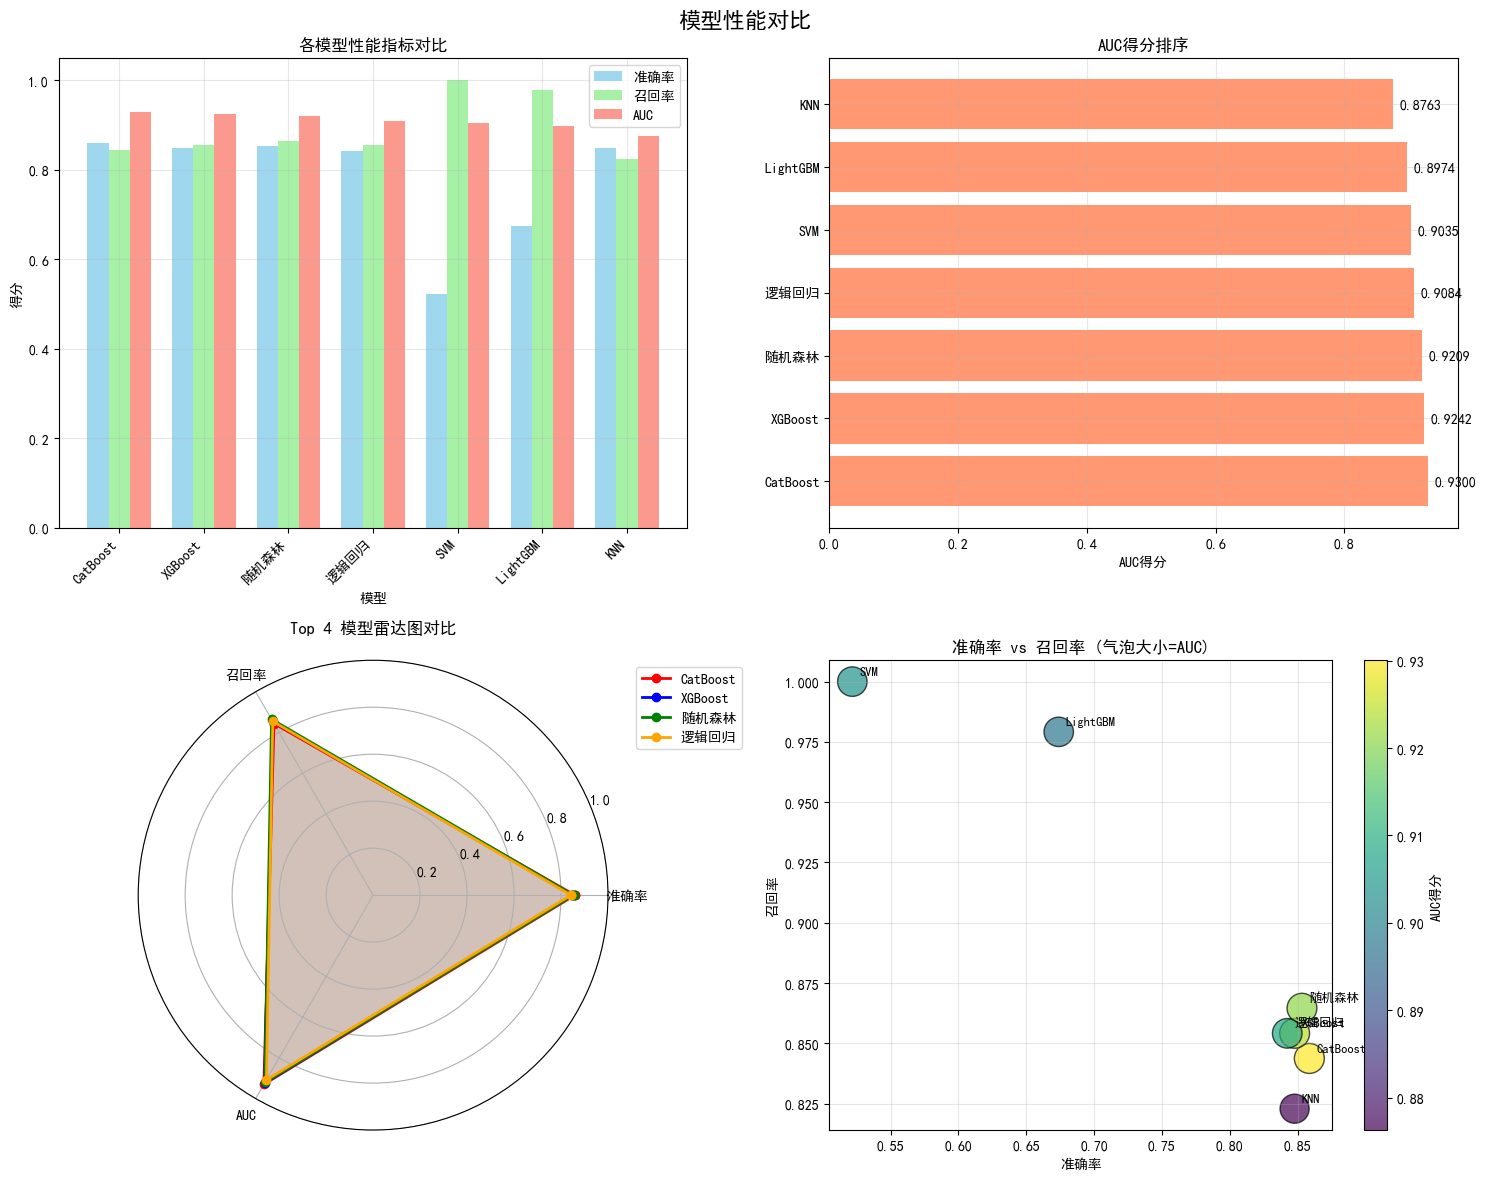

                    模型性能总结
      模型    准确率    召回率    AUC
CatBoost 0.8587 0.8438 0.9300
 XGBoost 0.8478 0.8542 0.9242
    随机森林 0.8533 0.8646 0.9209
    逻辑回归 0.8424 0.8542 0.9084
     SVM 0.5217 1.0000 0.9035
LightGBM 0.6739 0.9792 0.8974
     KNN 0.8478 0.8229 0.8763


In [42]:
def compare_all_models(X_test, y_test):
    """
    对比所有模型的性能
    使用图表展示对比结果
    """
    models = {
        'XGBoost': best_pipe,  # 使用网格搜索的最佳XGBoost模型
        'LightGBM': best_model,  # 使用Optuna优化的LightGBM模型
        'KNN': best_knn_model,
        'SVM': best_svm_model,
        '随机森林': best_rf_model,
        '逻辑回归': best_random_model,  # 使用随机搜索的最佳逻辑回归模型
        'GBDT': pipe_gbdt,  # 使用基础的GBDT管道
        'CatBoost': best_catboost_model
    }
    
    results = []
    
    for name, model in models.items():
        try:
            # 计算各项指标
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            accuracy = model.score(X_test, y_test)
            recall = recall_score(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            
            results.append({
                '模型': name,
                '准确率': accuracy,
                '召回率': recall,
                'AUC': auc_score
            })
        except Exception as e:
            print(f"模型 {name} 评估失败: {e}")
            continue
    
    # 转换为DataFrame并按AUC排序
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AUC', ascending=False)
    
    # 创建图表展示
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('模型性能对比', fontsize=16, fontweight='bold')
    
    # 1. 柱状图 - 所有指标
    ax1 = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.25
    
    ax1.bar(x - width, results_df['准确率'], width, label='准确率', alpha=0.8, color='skyblue')
    ax1.bar(x, results_df['召回率'], width, label='召回率', alpha=0.8, color='lightgreen')
    ax1.bar(x + width, results_df['AUC'], width, label='AUC', alpha=0.8, color='salmon')
    
    ax1.set_xlabel('模型')
    ax1.set_ylabel('得分')
    ax1.set_title('各模型性能指标对比')
    ax1.set_xticks(x)
    ax1.set_xticklabels(results_df['模型'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)
    
    # 2. AUC排序柱状图
    ax2 = axes[0, 1]
    bars = ax2.barh(results_df['模型'], results_df['AUC'], color='coral', alpha=0.8)
    ax2.set_xlabel('AUC得分')
    ax2.set_title('AUC得分排序')
    ax2.grid(True, alpha=0.3)
    
    # 在柱状图上添加数值
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center', fontweight='bold')
    
    # 3. 雷达图
    ax3 = axes[1, 0]
    ax3.remove()  # 移除原有的子图
    ax3 = fig.add_subplot(2, 2, 3, projection='polar')
    
    # 选择前4个模型进行雷达图对比
    top4_models = results_df.head(4)
    categories = ['准确率', '召回率', 'AUC']
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    colors = ['red', 'blue', 'green', 'orange']
    for i, (idx, row) in enumerate(top4_models.iterrows()):
        values = [row['准确率'], row['召回率'], row['AUC']]
        values += values[:1]  # 闭合图形
        ax3.plot(angles, values, 'o-', linewidth=2, label=row['模型'], color=colors[i])
        ax3.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories)
    ax3.set_ylim(0, 1)
    ax3.set_title('Top 4 模型雷达图对比', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.grid(True)
    
    # 4. 性能分布散点图
    ax4 = axes[1, 1]
    scatter = ax4.scatter(results_df['准确率'], results_df['召回率'], 
                         s=results_df['AUC']*500, alpha=0.7, c=results_df['AUC'], 
                         cmap='viridis', edgecolors='black')
    
    # 添加模型名称标注
    for i, row in results_df.iterrows():
        ax4.annotate(row['模型'], (row['准确率'], row['召回率']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax4.set_xlabel('准确率')
    ax4.set_ylabel('召回率')
    ax4.set_title('准确率 vs 召回率 (气泡大小=AUC)')
    ax4.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('AUC得分')
    
    plt.tight_layout()
    plt.show()
    
    # 输出简洁的表格总结
    print("=" * 60)
    print("                    模型性能总结")
    print("=" * 60)
    summary_df = results_df.copy()
    summary_df['准确率'] = summary_df['准确率'].apply(lambda x: f"{x:.4f}")
    summary_df['召回率'] = summary_df['召回率'].apply(lambda x: f"{x:.4f}")
    summary_df['AUC'] = summary_df['AUC'].apply(lambda x: f"{x:.4f}")
    print(summary_df.to_string(index=False))
    print("=" * 60)
    
    return results_df

# 执行对比
model_comparison = compare_all_models(X_test, y_test)

### 超参优化

In [43]:
# # 网格搜索&交叉验证
# from sklearn.model_selection import GridSearchCV

# params = {
#     'CatBoost__iterations': [100, 200, 300],
#     'CatBoost__learning_rate': [0.05, 0.1, 0.2],
#     'CatBoost__depth': [4, 6, 8],
#     'CatBoost__l2_leaf_reg': [1, 3, 5]
# }

# grid_search_cat = GridSearchCV(pipe_catboost, params, cv=5, scoring='roc_auc', verbose=1)
# grid_search_cat.fit(X_train, y_train)
# print_model_scores(grid_search_cat, X_test, y_test)

In [45]:
# 更快更高效的超参优化方法
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, recall_score
from catboost import CatBoostClassifier
import optuna
import time
import warnings
warnings.filterwarnings("ignore")

# 设置optuna日志级别，减少输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna目标函数：优化CatBoost关键参数
    只优化最重要的几个参数以提高效率
    """
    # 优化关键参数
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),  # 减少范围以提高速度
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),
        'random_state': 42,
        'verbose': False
    }
    
    # 创建模型
    model = CatBoostClassifier(**params)
    
    # 创建Pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("catboost", model)
    ])
    
    # 使用3折交叉验证评估AUC（减少折数以提高速度）
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc')
    
    return scores.mean()

print("🚀 开始CatBoost超参数优化")
print("=" * 50)
print("📊 优化目标: 最大化AUC得分")
print("⚡ 优化算法: TPE (Tree-structured Parzen Estimator)")
print("🎯 试验次数: 20次 (高效模式)")
print("=" * 50)

# 创建study并设置优化方向
study = optuna.create_study(direction='maximize', 
                           sampler=optuna.samplers.TPESampler(seed=42))

# 记录开始时间
start_time = time.time()

# 执行优化（减少试验次数以控制时间）
study.optimize(objective, n_trials=20, show_progress_bar=True)

# 记录结束时间
end_time = time.time()

print(f"\n✅ 优化完成！耗时: {end_time - start_time:.1f}秒")
print("=" * 50)
print("🏆 最佳参数:")
for key, value in study.best_params.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")
print(f"\n🎯 最佳AUC得分: {study.best_value:.4f}")

# 使用最佳参数训练最终模型
print("\n" + "=" * 50)
print("🔧 使用最佳参数训练模型...")

best_catboost_optimized = CatBoostClassifier(**study.best_params)
best_pipe_catboost_optimized = Pipeline([
    ("scaler", StandardScaler()),
    ("catboost", best_catboost_optimized)
])

best_pipe_catboost_optimized.fit(X_train, y_train)

print("✅ 训练完成！")
print("\n" + "=" * 50)
print("📈 优化后模型在测试集上的表现:")

# 简化的评估函数
y_pred = best_pipe_catboost_optimized.predict(X_test)
y_pred_proba = best_pipe_catboost_optimized.predict_proba(X_test)[:, 1]
accuracy = best_pipe_catboost_optimized.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"   准确率: {accuracy:.4f}")
print(f"   召回率: {recall:.4f}")
print(f"   AUC评分: {auc_score:.4f}")

# 对比优化前后的性能
print("\n" + "=" * 50)
print("📊 优化前后对比:")

# 使用已经训练好的best_catboost_model作为优化前的基线
try:
    original_auc = roc_auc_score(y_test, best_catboost_model.predict_proba(X_test)[:, 1])
    print(f"   优化前AUC (随机搜索): {original_auc:.4f}")
    print(f"   优化后AUC (Optuna): {auc_score:.4f}")
    improvement = auc_score - original_auc
    if improvement > 0:
        print(f"   🎉 性能提升: +{improvement:.4f}")
    else:
        print(f"   📝 性能变化: {improvement:.4f}")
except Exception as e:
    print(f"   ⚠️ 无法获取优化前基线，可能需要先运行CatBoost随机搜索单元格")
    print(f"   📊 当前优化后AUC: {auc_score:.4f}")

print("=" * 50)

# 保存优化后的模型以供后续使用
globals()['best_pipe_catboost'] = best_pipe_catboost_optimized
print("✅ 已将优化后的模型保存为 best_pipe_catboost")

🚀 开始CatBoost超参数优化
📊 优化目标: 最大化AUC得分
⚡ 优化算法: TPE (Tree-structured Parzen Estimator)
🎯 试验次数: 20次 (高效模式)


  0%|          | 0/20 [00:00<?, ?it/s]


✅ 优化完成！耗时: 19.7秒
🏆 最佳参数:
   iterations: 141
   learning_rate: 0.0956
   depth: 7
   l2_leaf_reg: 4.9046

🎯 最佳AUC得分: 0.9201

🔧 使用最佳参数训练模型...
0:	learn: 0.6562757	total: 1.94ms	remaining: 271ms
1:	learn: 0.6298877	total: 4.19ms	remaining: 291ms
2:	learn: 0.6016269	total: 6.21ms	remaining: 286ms
3:	learn: 0.5785436	total: 8.18ms	remaining: 280ms
4:	learn: 0.5579618	total: 10.2ms	remaining: 278ms
5:	learn: 0.5382570	total: 12.2ms	remaining: 275ms
6:	learn: 0.5235737	total: 14.1ms	remaining: 269ms
7:	learn: 0.5095401	total: 16.2ms	remaining: 270ms
8:	learn: 0.4917113	total: 17.8ms	remaining: 261ms
9:	learn: 0.4775511	total: 19.7ms	remaining: 258ms
10:	learn: 0.4661711	total: 20.4ms	remaining: 241ms
11:	learn: 0.4552562	total: 22.3ms	remaining: 240ms
12:	learn: 0.4464568	total: 24.2ms	remaining: 238ms
13:	learn: 0.4373103	total: 26.3ms	remaining: 238ms
14:	learn: 0.4282094	total: 28.1ms	remaining: 236ms
15:	learn: 0.4208107	total: 29.8ms	remaining: 233ms
16:	learn: 0.4111675	total: 31ms	rema

### 模型融合

In [49]:
# 模型融合：使用表现最好的几个模型进行集成
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

print("🔥 开始模型融合")
print("=" * 50)

# 1. 选择表现最好的几个基础模型
# 注意：使用已经训练好的模型，而不是基础管道
base_models = [
    ('catboost', best_catboost_model),  # 使用已训练的CatBoost模型
    ('lightgbm', best_model), 
    ('xgboost', best_pipe),  # 使用网格搜索的最佳XGBoost模型
    ('random_forest', best_rf_model)  # 使用随机森林模型
]

print("📊 基础模型:")
for name, model in base_models:
    print(f"   - {name}")

# 2. 软投票集成（使用预测概率）
print("\n🗳️  方法1: 软投票集成")
voting_clf = VotingClassifier(
    estimators=base_models,
    voting='soft'  # 使用预测概率进行投票
)

voting_clf.fit(X_train, y_train)
print("✅ 训练完成")

print("📈 软投票集成结果:")
print_model_scores(voting_clf, X_test, y_test)

# 3. 堆叠集成（使用逻辑回归作为元学习器）
print("\n" + "=" * 50)
print("🏗️  方法2: 堆叠集成")
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),  # 元学习器
    cv=3  # 3折交叉验证生成元特征
)

stacking_clf.fit(X_train, y_train)
print("✅ 训练完成")

print("📈 堆叠集成结果:")
print_model_scores(stacking_clf, X_test, y_test)

# 4. 性能对比
print("\n" + "=" * 50)
print("📊 融合效果对比")
print("=" * 50)

# 使用已经训练好的模型进行对比
models_comparison = {
    'CatBoost(单模型)': best_catboost_model,  # 使用已训练的CatBoost模型
    'LightGBM(单模型)': best_model,
    '软投票集成': voting_clf,
    '堆叠集成': stacking_clf
}

results = []
for name, model in models_comparison.items():
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        accuracy = model.score(X_test, y_test)
        results.append({
            '模型': name,
            '准确率': f"{accuracy:.4f}",
            'AUC': f"{auc_score:.4f}"
        })
    except Exception as e:
        print(f"模型 {name} 评估失败: {e}")
        continue

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AUC', key=lambda x: x.astype(float), ascending=False)

print(results_df.to_string(index=False))

# 5. 找出最佳模型
if len(results_df) > 0:
    best_model_name = results_df.iloc[0]['模型']
    best_auc = results_df.iloc[0]['AUC']
    
    print("\n" + "=" * 50)
    print(f"🏆 最佳模型: {best_model_name}")
    print(f"🎯 最佳AUC: {best_auc}")
    print("=" * 50)
    
    # 6. 额外的融合模型性能分析
    print("\n" + "=" * 50)
    print("📈 融合效果分析:")
    
    # 获取单模型和融合模型的AUC分数
    single_models = [row for row in results if '集成' not in row['模型']]
    ensemble_models = [row for row in results if '集成' in row['模型']]
    
    if single_models and ensemble_models:
        best_single = max(single_models, key=lambda x: float(x['AUC']))
        best_ensemble = max(ensemble_models, key=lambda x: float(x['AUC']))
        
        print(f"最佳单模型: {best_single['模型']} (AUC: {best_single['AUC']})")
        print(f"最佳融合模型: {best_ensemble['模型']} (AUC: {best_ensemble['AUC']})")
        
        improvement = float(best_ensemble['AUC']) - float(best_single['AUC'])
        if improvement > 0:
            print(f"🎉 融合提升: +{improvement:.4f}")
        else:
            print(f"📝 融合效果: {improvement:.4f}")
    
    print("=" * 50)
else:
    print("⚠️ 没有成功评估的模型")

🔥 开始模型融合
📊 基础模型:
   - catboost
   - lightgbm
   - xgboost
   - random_forest

🗳️  方法1: 软投票集成
✅ 训练完成
📈 软投票集成结果:
模型得分: 0.8641304347826086
召回率: 0.8541666666666666
AUC评分: 0.9272017045454546

🏗️  方法2: 堆叠集成
✅ 训练完成
📈 软投票集成结果:
模型得分: 0.8641304347826086
召回率: 0.8541666666666666
AUC评分: 0.9272017045454546

🏗️  方法2: 堆叠集成
✅ 训练完成
📈 堆叠集成结果:
模型得分: 0.8641304347826086
召回率: 0.8541666666666666
AUC评分: 0.9277935606060606

📊 融合效果对比
✅ 训练完成
📈 堆叠集成结果:
模型得分: 0.8641304347826086
召回率: 0.8541666666666666
AUC评分: 0.9277935606060606

📊 融合效果对比
           模型    准确率    AUC
CatBoost(单模型) 0.8587 0.9300
         堆叠集成 0.8641 0.9278
        软投票集成 0.8641 0.9272
LightGBM(单模型) 0.6739 0.8974

🏆 最佳模型: CatBoost(单模型)
🎯 最佳AUC: 0.9300

📈 融合效果分析:
最佳单模型: CatBoost(单模型) (AUC: 0.9300)
最佳融合模型: 堆叠集成 (AUC: 0.9278)
📝 融合效果: -0.0022
           模型    准确率    AUC
CatBoost(单模型) 0.8587 0.9300
         堆叠集成 0.8641 0.9278
        软投票集成 0.8641 0.9272
LightGBM(单模型) 0.6739 0.8974

🏆 最佳模型: CatBoost(单模型)
🎯 最佳AUC: 0.9300

📈 融合效果分析:
最佳单模型: CatBoost(单模型) (AUC: 0.